### import

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Data

In [2]:
data = pd.read_csv("telemetry_2021fall.csv", na_values=np.nan)
codebook = pd.read_excel("codeSpark_telemetry_codebook.xlsx")
df_nonan = data.dropna()
df_nonan.shape

(0, 33)

In [3]:
data.head()

,index,childId,date,time,chapter,level,session,serialNumber,attempt,trial,...,solType,repoBefore,repoAfter,repoBeforeEdit,repoAfterEdit,avtxyz,pathDist2opt,step,inxOptPath,stepsOptPath
0,926245,301,2021-09-24,08:11:13,1.0,1.0,2.0,12,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,926244,301,2021-09-24,08:11:13,1.0,1.0,2.0,13,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,926196,301,2021-09-24,08:11:17,1.0,1.0,2.0,14,1.0,1.0,...,1,NaN,['Walk.Right'],NaN,Walk.R,NaN,NaN,NaN,NaN,NaN
3,926169,301,2021-09-24,08:11:19,1.0,1.0,2.0,15,1.0,1.0,...,1,['Walk.Right'],NaN,Walk.R,NaN,"0.00,0.02,0.00",NaN,NaN,NaN,NaN
4,926168,301,2021-09-24,08:11:19,1.0,1.0,2.0,17,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,"0.00,0.02,0.00",0.0,0.0,0.0,2.0


In [4]:
codebook.head()

,Name,Description,Rule or Formula,Values
0,index,unique row number created in python,NaN,NaN
1,childId,Internal Child ID,internal mapping,100-199: data collection 2019-20\n200-299: dat...
2,chapter,codeSpark chapter,as defined by codeSpark,1: Donut Detective Chapter\n2: ...\n3: ...\n4:...
3,level,codeSpark level,as defined by codeSpark,"1-19, each chapter has a different number of l..."
4,session,codeSpark session,as defined by codeSpark: a session starts at a...,"1, 2, 3 .."


In [6]:
data.shape

(401940, 33)

In [7]:
data.columns

Index(['index', 'childId', 'date', 'time', 'chapter', 'level', 'session',
       'serialNumber', 'attempt', 'trial', 'pause_s', 'sessionTimestamp',
       'sms', 'eventDescription', 'param', 'avtPos', 'distChange',
       'dist2optMax', 'dist2optBefore', 'dist2optAfter', 'nofCmdsBest',
       'nofCmdsBefore', 'nofCmdsAfter', 'solType', 'repoBefore', 'repoAfter',
       'repoBeforeEdit', 'repoAfterEdit', 'avtxyz', 'pathDist2opt', 'step',
       'inxOptPath', 'stepsOptPath'],
      dtype='object')

In [8]:
# dealing with NaN
data.isnull().sum()

index                    0
childId                  0
date                     0
time                     0
chapter                216
level                  216
session                  0
serialNumber             0
attempt                  0
trial                    0
pause_s                747
sessionTimestamp         0
sms                      0
eventDescription         0
param               264916
avtPos               78574
distChange          299980
dist2optMax         299980
dist2optBefore      299980
dist2optAfter       299980
nofCmdsBest         299980
nofCmdsBefore       299980
nofCmdsAfter        299980
solType             284333
repoBefore          272059
repoAfter           303233
repoBeforeEdit      272059
repoAfterEdit       303233
avtxyz              137242
pathDist2opt        280450
step                280450
inxOptPath          280450
stepsOptPath        280450
dtype: int64

In [9]:
df = data.copy()

In [10]:
df.drop(columns = ['index', 'param', 'avtPos', 'distChange',
       'dist2optMax', 'dist2optBefore', 'dist2optAfter', 'nofCmdsBest',
       'nofCmdsBefore', 'nofCmdsAfter', 'solType', 'repoBefore', 'repoAfter',
       'repoBeforeEdit', 'repoAfterEdit', 'avtxyz', 'pathDist2opt', 'step',
       'inxOptPath', 'stepsOptPath'], inplace = True)

In [11]:
df.head()

,childId,date,time,chapter,level,session,serialNumber,attempt,trial,pause_s,sessionTimestamp,sms,eventDescription
0,301,2021-09-24,08:11:13,1.0,1.0,2.0,12,0.0,1.0,NaN,767832.907,0.0,PuzzleIntroDone
1,301,2021-09-24,08:11:13,1.0,1.0,2.0,13,1.0,1.0,0.1,767841.254,0.0,PuzzleStart
2,301,2021-09-24,08:11:17,1.0,1.0,2.0,14,1.0,1.0,3.8,771640.313,3.8,CommandAdded
3,301,2021-09-24,08:11:19,1.0,1.0,2.0,15,1.0,1.0,2.0,773623.663,5.8,StartExecuteTrigger
4,301,2021-09-24,08:11:19,1.0,1.0,2.0,17,1.0,1.0,0.2,773751.507,5.9,ExecuteTriggerCommand


In [41]:
codebook.head(2)
codebook = codebook.T

new_header = codebook.iloc[0] #grab the first row for the header
codebook.columns = new_header #set the header row as the df header

codebook[['childId',
 'date',
 'time',
 'chapter',
 'level',
 'session',
#  'serialNumber',
 'attempt',
 'trial',
 'pause_s',
#  'sessionTimestamp',
 'sms']]
#  'eventDescription']]

index,childId,date,time,chapter,level,session,attempt,trial,pause_s,sms
index,,,,,,,,,,
index,childId,date,time,chapter,level,session,attempt,trial,pause_s,sms
unique row number created in python,Internal Child ID,event data in format YYYY-MM-DD,event time in Pacific Time in format HH:mm:ss,codeSpark chapter,codeSpark level,codeSpark session,"Part of a session, an attempt includes startin...",Part of an attempt. Each edit/execute sequence...,NaN,NaN
NaN,internal mapping,NaN,NaN,as defined by codeSpark,as defined by codeSpark,as defined by codeSpark: a session starts at a...,starts at PuzzleStart\nends at PuzzleResult,starts at PuzzleStart\nends at [EndExecuteTrig...,NaN,NaN
NaN,100-199: data collection 2019-20\n200-299: dat...,NaN,NaN,1: Donut Detective Chapter\n2: ...\n3: ...\n4:...,"1-19, each chapter has a different number of l...","1, 2, 3 ..","1, 2, 3 .. (starts at 1 for each session)","1, 2, 3 .. (starts at 1 for each attempt)",NaN,NaN


In [42]:
df.head()

,childId,date,time,chapter,level,session,serialNumber,attempt,trial,pause_s,sessionTimestamp,sms,eventDescription
0,301,2021-09-24,08:11:13,1.0,1.0,2.0,12,0.0,1.0,NaN,767832.907,0.0,PuzzleIntroDone
1,301,2021-09-24,08:11:13,1.0,1.0,2.0,13,1.0,1.0,0.1,767841.254,0.0,PuzzleStart
2,301,2021-09-24,08:11:17,1.0,1.0,2.0,14,1.0,1.0,3.8,771640.313,3.8,CommandAdded
3,301,2021-09-24,08:11:19,1.0,1.0,2.0,15,1.0,1.0,2.0,773623.663,5.8,StartExecuteTrigger
4,301,2021-09-24,08:11:19,1.0,1.0,2.0,17,1.0,1.0,0.2,773751.507,5.9,ExecuteTriggerCommand


In [45]:
df.columns

Index(['childId', 'date', 'time', 'chapter', 'level', 'session',
       'serialNumber', 'attempt', 'trial', 'pause_s', 'sessionTimestamp',
       'sms', 'eventDescription'],
      dtype='object')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401940 entries, 0 to 401939
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   childId           401940 non-null  int64  
 1   date              401940 non-null  object 
 2   time              401940 non-null  object 
 3   chapter           401724 non-null  float64
 4   level             401724 non-null  float64
 5   session           401940 non-null  float64
 6   serialNumber      401940 non-null  int64  
 7   attempt           401940 non-null  float64
 8   trial             401940 non-null  float64
 9   pause_s           401193 non-null  float64
 10  sessionTimestamp  401940 non-null  float64
 11  sms               401940 non-null  float64
 12  eventDescription  401940 non-null  object 
dtypes: float64(8), int64(2), object(3)
memory usage: 39.9+ MB


No handles with labels found to put in legend.


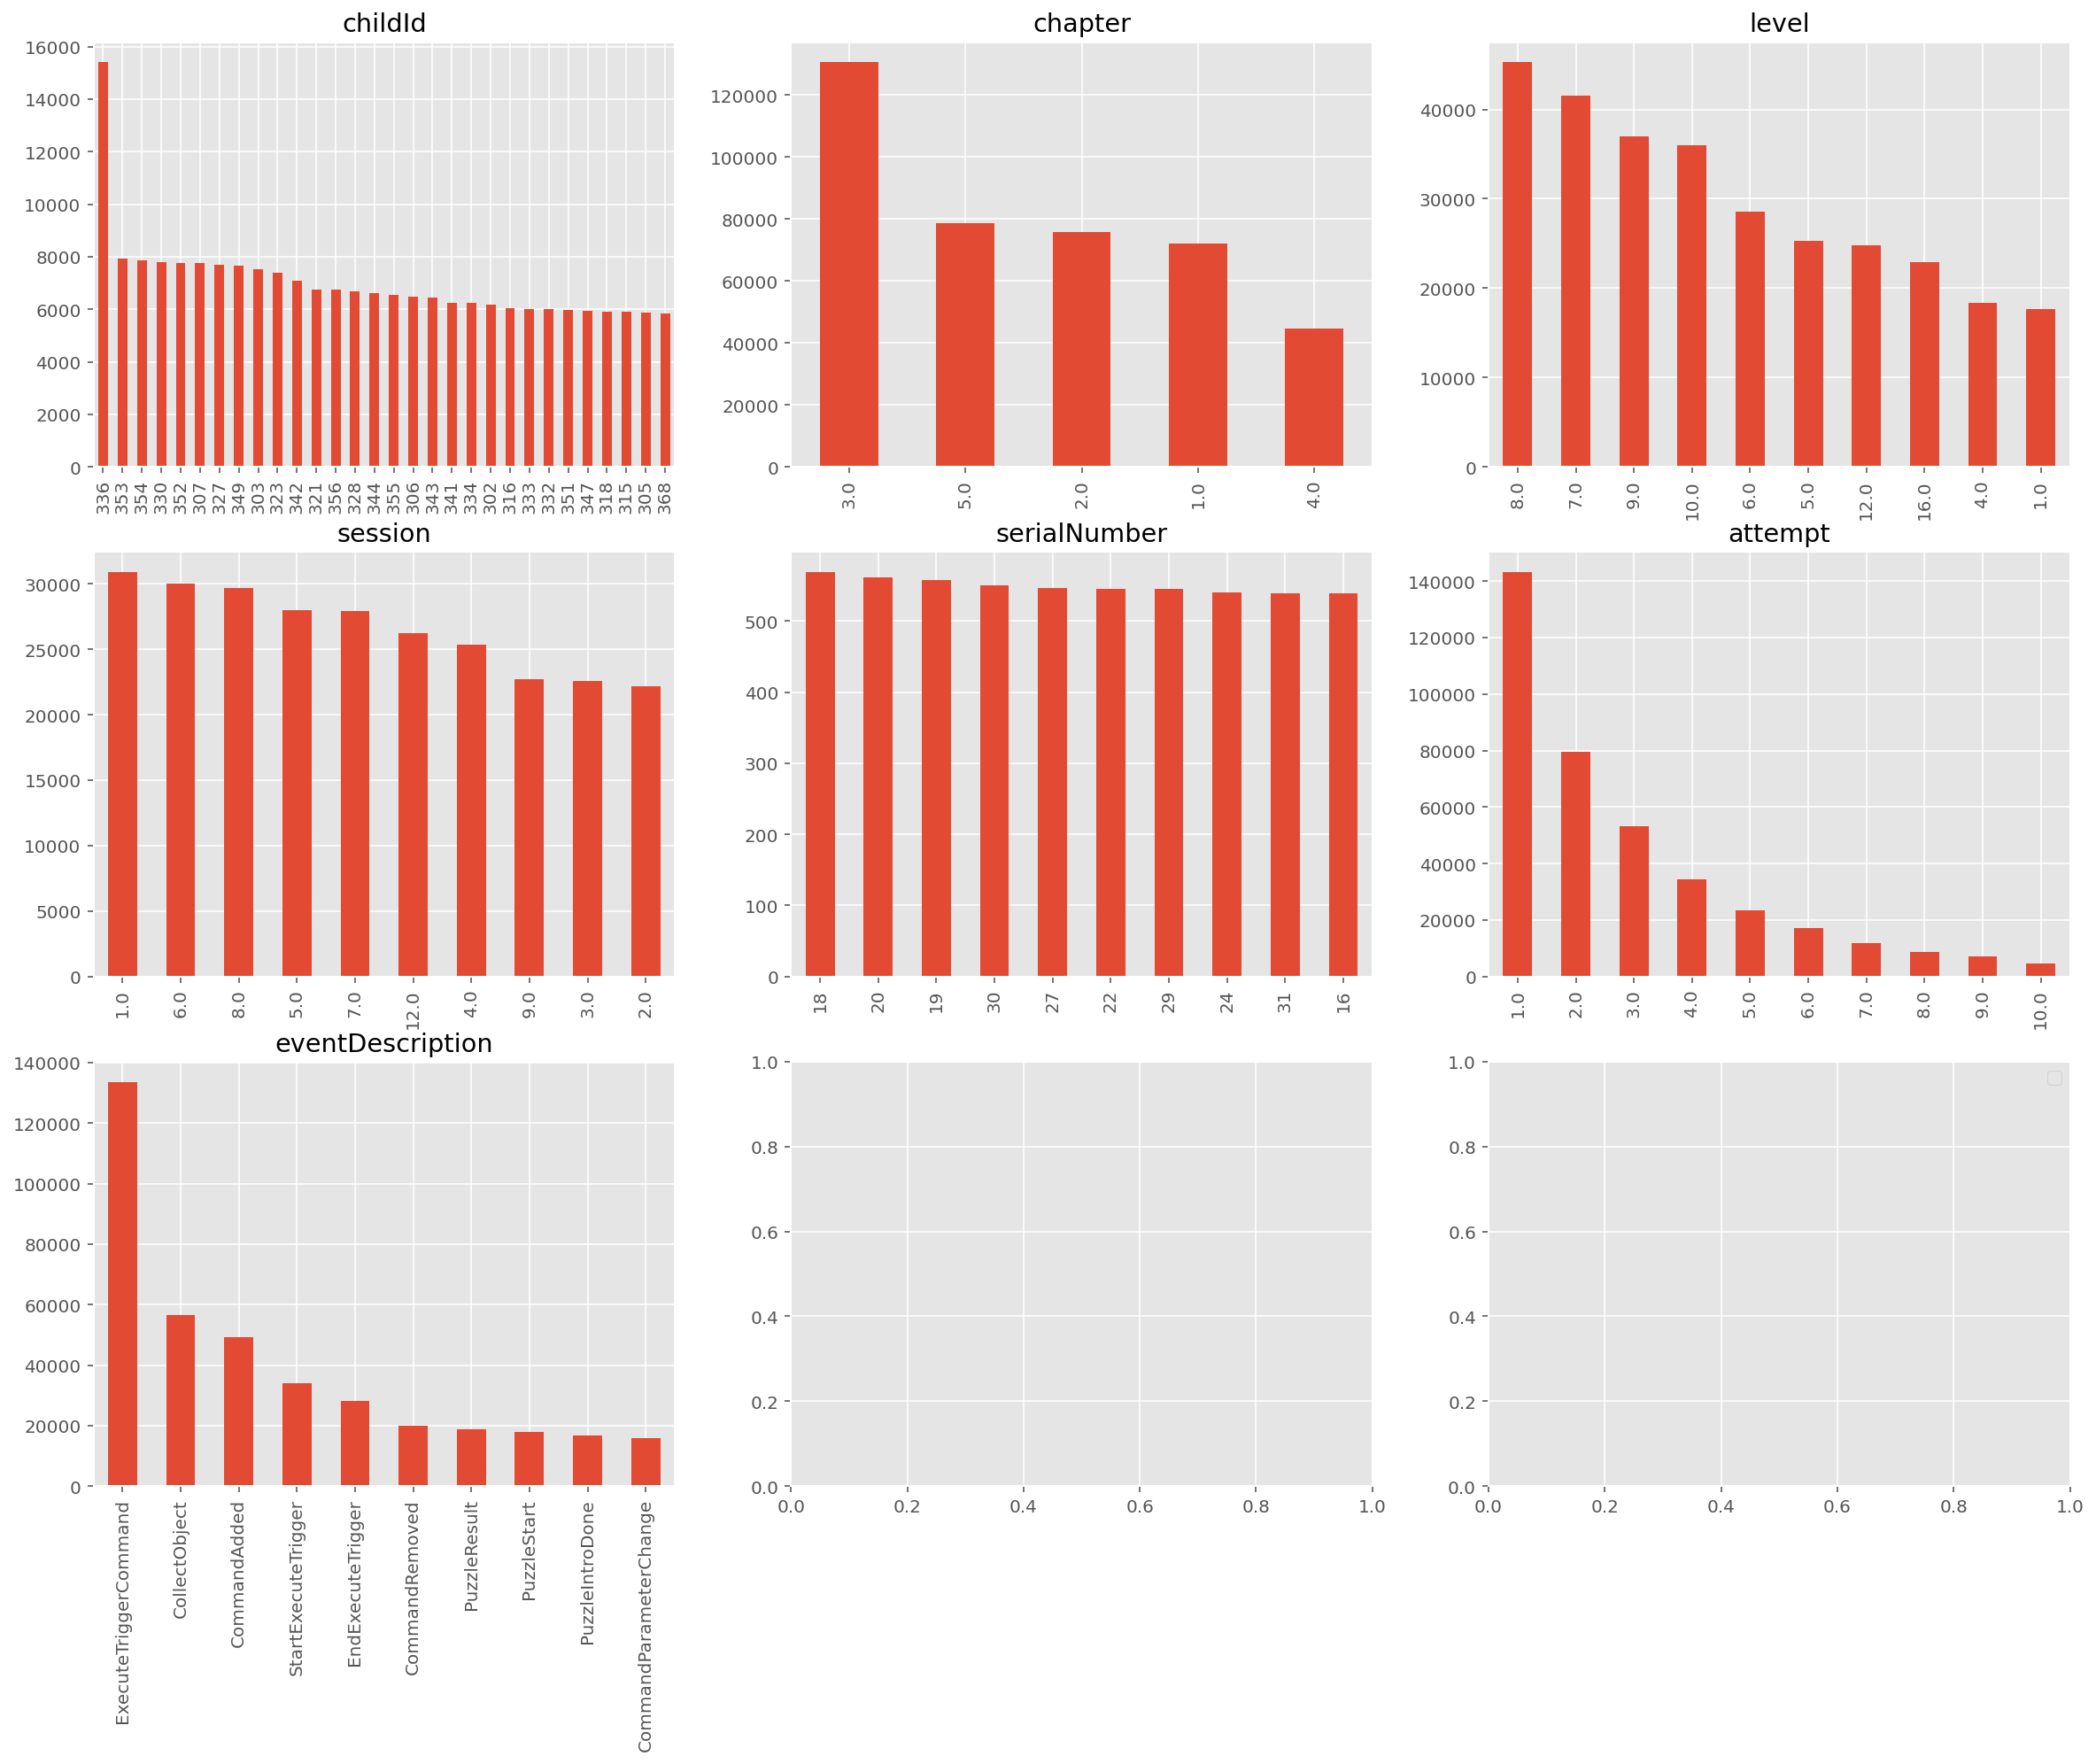

In [49]:
fig, ax = plt.subplots(3, 3, figsize = (20,15))
df['childId'].value_counts().head(30).plot(ax=ax[0][0], kind='bar', title ="childId")
df['chapter'].value_counts().head(10).plot(ax=ax[0][1], kind='bar', title ="chapter")
df['level'].value_counts().head(10).plot(ax=ax[0][2], kind='bar', title ="level")
df['session'].value_counts().head(10).plot(ax=ax[1][0], kind='bar', title ="session")
df['serialNumber'].value_counts().head(10).plot(ax=ax[1][1], kind='bar', title ="serialNumber")
df['attempt'].value_counts().head(10).plot(ax=ax[1][2], kind='bar', title ="attempt")
df['trial'].value_counts().head(10).plot(ax=ax[2][0], kind='bar', title ="trial")
df['pause_s'].value_counts().head(10).plot(ax=ax[2][0], kind='bar', title ="pause_s")
df['sessionTimestamp'].value_counts().head(10).plot(ax=ax[2][0], kind='bar', title ="sessionTimestamp")
df['sms'].value_counts().head(10).plot(ax=ax[2][0], kind='bar', title ="sms")
df['eventDescription'].value_counts().head(10).plot(ax=ax[2][0], kind='bar', title ="eventDescription")
plt.legend()

In [51]:
for col in df.columns:
    print('{} : {} unique values'.format(col, len(df[col].unique())))

childId : 73 unique values
date : 59 unique values
time : 29306 unique values
chapter : 6 unique values
level : 18 unique values
session : 37 unique values
serialNumber : 3527 unique values
attempt : 31 unique values
trial : 197 unique values
pause_s : 1881 unique values
sessionTimestamp : 401894 unique values
sms : 5014 unique values
eventDescription : 15 unique values


In [52]:
df.corr()

,childId,chapter,level,session,serialNumber,attempt,trial,pause_s,sessionTimestamp,sms
childId,1.000000,-0.001792,-0.019957,-0.054747,-0.040690,-0.002106,0.023609,0.000428,0.011545,0.035055
chapter,-0.001792,1.000000,-0.301134,0.438380,0.124679,-0.074157,0.202468,0.001656,0.018513,0.109622
level,-0.019957,-0.301134,1.000000,0.148301,0.171309,0.194511,0.066577,-0.001268,0.001426,0.014195
session,-0.054747,0.438380,0.148301,1.000000,0.045573,0.044966,0.070258,0.002656,0.018098,0.050370
serialNumber,-0.040690,0.124679,0.171309,0.045573,1.000000,0.250510,0.197868,0.007417,0.210580,0.017144
attempt,-0.002106,-0.074157,0.194511,0.044966,0.250510,1.000000,0.608226,-0.001013,-0.000575,-0.045878
trial,0.023609,0.202468,0.066577,0.070258,0.197868,0.608226,1.000000,-0.002124,0.012039,0.054111
pause_s,0.000428,0.001656,-0.001268,0.002656,0.007417,-0.001013,-0.002124,1.000000,0.002465,0.102262
sessionTimestamp,0.011545,0.018513,0.001426,0.018098,0.210580,-0.000575,0.012039,0.002465,1.000000,0.037832
sms,0.035055,0.109622,0.014195,0.050370,0.017144,-0.045878,0.054111,0.102262,0.037832,1.000000
